# Regression Models

The following is a in depth demonstration of the regression models in Darts : starting from some basics, some advanced features and subtilities will then be detailed.

The following topics are covered in this notebook :
* [Basics](#basics)
    * [Lags](#target-and-covariates-lags)
        * [Covariates-based forecasting](#covariates-based-forecasting)
        * [Component-specific lags](#component-specific-lags)
    * [Output chunk length](#models-output-chunk-length)
        * [Multi-models forecasting](#multi-model-forecasting)
        * [Single-model forecasting](#single-model-forecasting)
* [Darts models](#darts-regressionmodel)
    * [Probabilistic forecasting](#probabilistic-forecasting)
* [Sklearn-like models](#sklearn-like-models)
    * [Built-in model](#built-in-model)
    * [MultiOutputRegressor wrapper](#multioutputregressor-wrapper)
    * [Custom model](#custom-model)
* [External librairies](#external-librairies)
* [Explainability](#explainability)

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

# activate javascript
from shap import initjs

initjs()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import BayesianRidge

from darts.models import (
    LinearRegressionModel,
    RegressionModel,
    LightGBMModel,
    XGBModel,
    CatBoostModel,
)
from darts.metrics import mape
from darts.datasets import EnergyConsumptionZurichDataset, WeatherZurichDataset
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.explainability import ShapExplainer
from darts.logging import raise_if

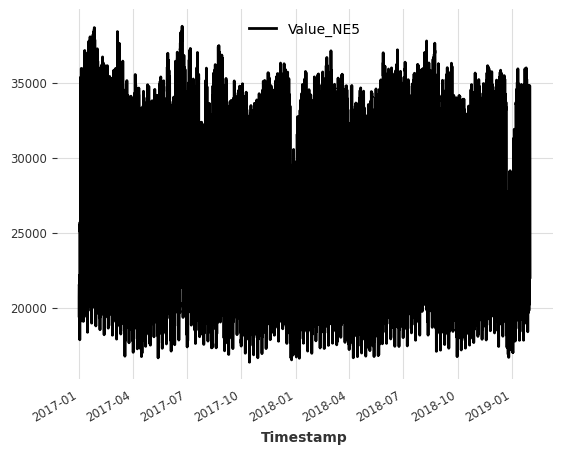

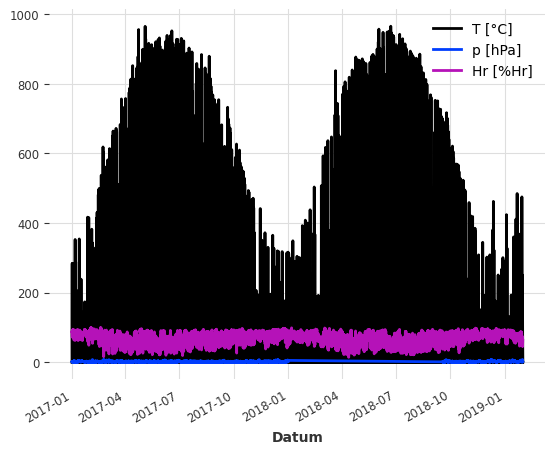

In [3]:
ts_energy = EnergyConsumptionZurichDataset().load()
ts_weather = WeatherZurichDataset().load()

# extract values recorded between 2017 and 2019
start_date = pd.Timestamp("2017-01-01")
end_date = pd.Timestamp("2019-01-31")
ts_energy = ts_energy[start_date:end_date]
ts_weather = ts_weather[start_date:end_date]

# fill missing values
filler = MissingValuesFiller()
ts_energy = filler.transform(ts_energy)
ts_weather = filler.transform(ts_weather)

# resample energy series to match weather frequency
ts_energy = ts_energy.resample(freq="H")

# extract households energy consumption
ts_energy = ts_energy["Value_NE5"]

# extract temperature, pressure and relative humidity
ts_weather = ts_weather[["T [°C]", "p [hPa]", "Hr [%Hr]"]]

ts_energy.plot()
plt.show()

ts_weather.plot()
plt.show()

In [4]:
# split and scaling
validation_cutoff = pd.Timestamp("2018-10-31")

scaler_energy = Scaler()
ts_energy_train, ts_energy_val = ts_energy.split_after(validation_cutoff)
ts_energy_train = scaler_energy.fit_transform(ts_energy_train)
ts_energy_val = scaler_energy.transform(ts_energy_val)

scaler_weather = Scaler()
ts_weather_past, ts_weather_future = ts_weather.split_after(validation_cutoff)
ts_weather_past = scaler_weather.fit_transform(ts_weather_past)
ts_weather_future = scaler_weather.transform(ts_weather_future)
# pretending that after the val cutoff, the values are forecasts, not observed values
ts_weather = ts_weather_past.append(ts_weather_future)

## Basics

Regression is a statistical method used in data science and machine learning to model the relationship between a dependent variable (target) and one or more independent variables (features).

In Darts, the timeseries forecasting problem is translated into a regression problem by transforming the series is converted into two arrays:
- features or input array with the shape (number of samples, number of features, 1)
- target or label array with the shape (number of samples, number of targets, 1)

The number of features is impacted by the definition of the lags and the shape of the past and/or future covariates used; each lag value corresponds to one feature.

## Target and covariates lags

The choice of the lags is critical to ensure that the model has access to the information at the relevant timestamps and have a considerable impact on the performance of the model.

For example, let's imagine that a model needs to predict the energy consumption for the next hour based on the demand on the same hour of the last two days : using `lags=[-24, -48]` will allow the model to access these two values while ignoring all the other.

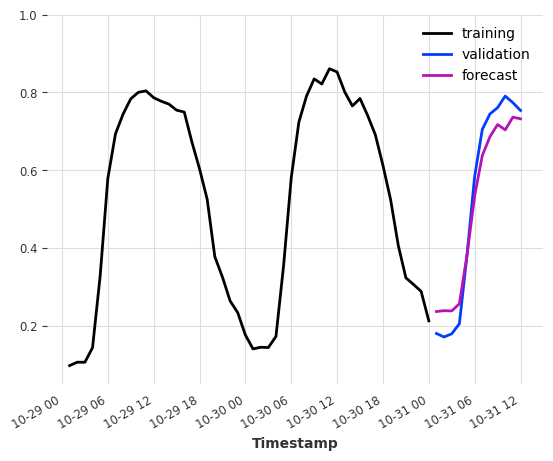

In [5]:
model = LinearRegressionModel(lags=[-24, -48])
model.fit(ts_energy_train)
pred = model.predict(12)
ts_energy_train[-48:].plot(label="training")
ts_energy_val[:12].plot(label="validation")
pred.plot(label="forecast")
plt.ylim(0.05, 1);

### Covariates-based forecasting

In some scenarios, one might be interested in having a model that produce forecasts without relying on the values of the target. This kind of constraint can occur if the values of the target are not accessible at inference time because of some external dependencies.

To do so, at least one of `lags_past_covariates` or `lags_future_covariates` must be defined at model creation and `lags=None`. Since Darts regression models are trained in a supervised manner, the target series must of course still be provided during training.

In the example below, the model forecast the next hour energy demand based on the weather measurements of the last 48 hours as well as the the upcoming 24 hours (let's pretend the weather forecast is perfectly accurate for this period).

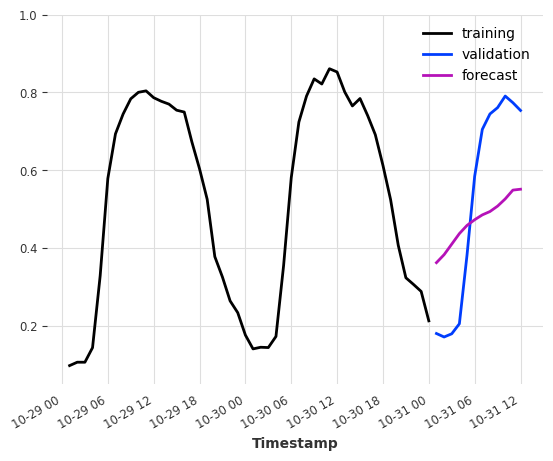

In [6]:
model = LinearRegressionModel(lags=None, lags_future_covariates=(48, 0))
model.fit(series=ts_energy_train, future_covariates=ts_weather)
pred = model.predict(12)
ts_energy_train[-48:].plot(label="training")
ts_energy_val[:12].plot(label="validation")
pred.plot(label="forecast")
plt.ylim(0.05, 1);

### Component-specific lags

If the target or any of the covariates is multivariate, one might be interested in using different lags for each of the components. In Darts, this can be achieve by passing a dictionnary to the `lags*` argument with the name of the component as key and the lags as value.

In the example below, the default set of lags as `(24,12)` (used for the future covariates components `'T [°C]'` and `'p [hPa]'`) whereas the `'Hr [%Hr]'` component uses the `(24,0)` lags values.

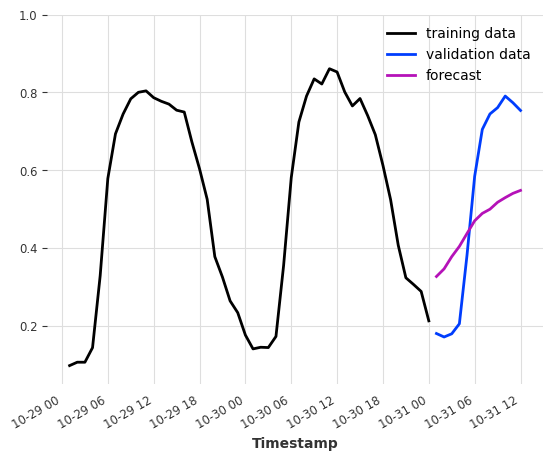

In [7]:
model = LinearRegressionModel(
    lags=None, lags_future_covariates={"default_lags": (48, 0), "Hr [%Hr]": (24, 12)}
)
model.fit(series=ts_energy_train, future_covariates=ts_weather)
pred = model.predict(12)
ts_energy_train[-48:].plot(label="training data")
ts_energy_val[:12].plot(label="validation data")
pred.plot(label="forecast")
plt.ylim(0.05, 1);

## Model's output chunk length

This key parameter allows to indicate the `number of time steps predicted at once by the internal regression model`, not to be mistaken with the forecast horizon `n` which corresponds to the number of values returned by `predict()` using auto-regression if `output_chunk_length < n`,  or single shot forecasting otherwise.

For example, if the model is expected to forecast the weekly sales of a shop based on the last two weeks transactions, setting `output_chunk_length=7` could be benefitial as the model won't have to rely on its own forecasts to predict the values for the end of the week

When `output_chunk_length>1`, the model behavior can be further parametrized by modifying the `multi_model` argument.

### Multi-model forecasting

It corresponds to the default behavior in Darts (`multi_model=True`) : one copy of the model will be trained to predict each value in the forecasted period using the same inputs. This approach is more computationally and memory intensive but tends to yield better results.

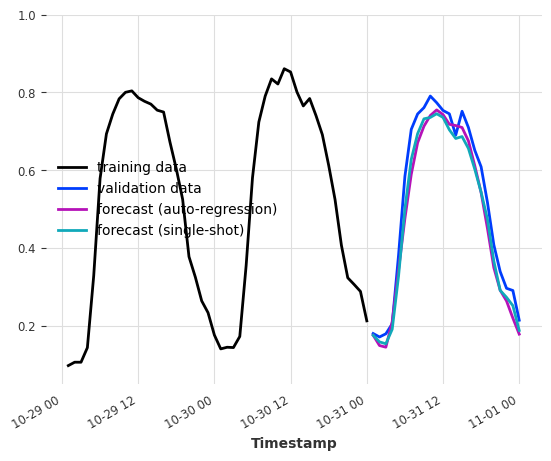

In [8]:
model_auto_regression = LinearRegressionModel(lags=24, output_chunk_length=1)
model_single_shot = LinearRegressionModel(lags=24, output_chunk_length=24)

model_auto_regression.fit(ts_energy_train)
model_single_shot.fit(ts_energy_train)

pred_auto_regression = model_auto_regression.predict(24)
pred_single_shot = model_single_shot.predict(24)

ts_energy_train[-48:].plot(label="training data")
ts_energy_val[:24].plot(label="validation data")
pred_auto_regression.plot(label="forecast (auto-regression)")
pred_single_shot.plot(label="forecast (single-shot)")
plt.ylim(0.05, 1);

### Single-model forecasting

When `multi_model=False`, a single model will be used to predict the entire forecasted period, reducing the model complexity as a single set of coefficients will be trained and stored.

Using this approach will induce lags shifts during the tabularization to insure that the inputs for each forecasted values are different without relying on timesteps in the period being forecasted. Hence, the minimum length requirement for the training series will be increased.

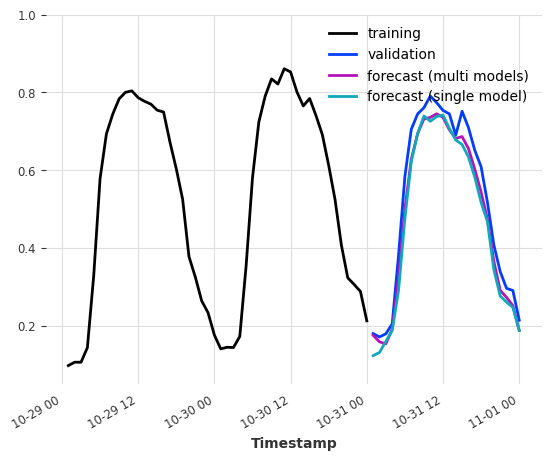

In [9]:
multi_models = LinearRegressionModel(lags=24, output_chunk_length=24, multi_models=True)
single_model = LinearRegressionModel(
    lags=24, output_chunk_length=24, multi_models=False
)

multi_models.fit(ts_energy_train)
single_model.fit(ts_energy_train)

pred_multi_models = multi_models.predict(24)
pred_single_model = single_model.predict(24)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:24].plot(label="validation")
pred_multi_models.plot(label="forecast (multi models)")
pred_single_model.plot(label="forecast (single model)")
plt.ylim(0.05, 1);

To vizualize what is happening under the hood, let's simplify the model a little bit and assume that it was created with `RegressionModel(lags=[-4, -3, -2, -1], output_chunk_length=2, multi_model=False)`, the input series is processed as follow when `predict(n=4)` is called :

![forecast_single_model_ocl2](./static/images/single_model_ocl2.png)

Since `n>output_chunk_length`, the model had to use auto-regression and the forecasted period is composed of two chunks of size `output_chunk_length`.

If the model was created with `RegressionModel(lags=[-4, -3, -2, -1], output_chunk_length=3, multi_model=False)`, the forecasting process would look like this:

![forecast_single_model_ocl3](./static/images/single_model_ocl3.png)

For reference, an illustration of the process when the model is created with `RegressionModel(lags=[-4, -3, -2, -1], output_chunk_length=2, multi_model=True)` (default behavior):

![forecast_multi_model_ocl2](./static/images/multi_model_ocl2.png)

Of course, the same process occurs during tabularizion for the training: each green chunk is paired with an orange value, constituting the training dataset.

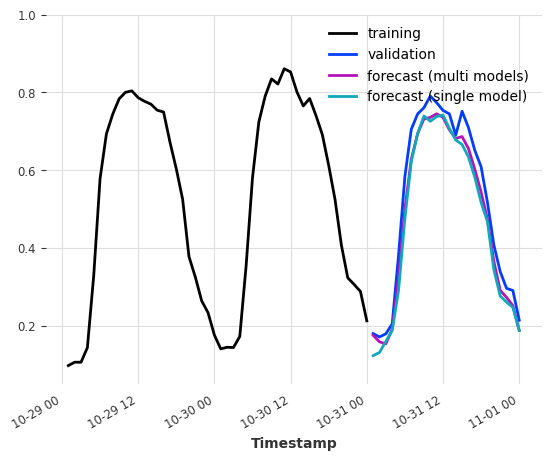

In [10]:
multi_models = LinearRegressionModel(lags=24, output_chunk_length=24, multi_models=True)
single_model = LinearRegressionModel(
    lags=24, output_chunk_length=24, multi_models=False
)

multi_models.fit(ts_energy_train)
single_model.fit(ts_energy_train)

pred_multi_models = multi_models.predict(24)
pred_single_model = single_model.predict(24)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:24].plot(label="validation")
pred_multi_models.plot(label="forecast (multi models)")
pred_single_model.plot(label="forecast (single model)")
plt.ylim(0.05, 1);

## Darts RegressionModel

For convenience, Darts provides two ready-made models based on `sklearn` implementations: `LinearRegressionModel`, which also come with some additional features for probabilistic forecasting and `RandomForest`.

Due to their simplicity of use and architectures, these models are excellent starting points for any forecasting problem.

### Probabilistic forecasting

The parameter `likelihood` can be set to either `quantile` or `poisson` when creating a `RegressionModel` in order to make them probabilistic. At prediction time, probabilistic models can either :
- use Monte Carlo sampling to generate samples based on the fitted distribution parameters when `num_samples > 1`
- return the fitted distribution parameters when `predict_likelihood_parameters=True`

Note that when using the `quantile` regressor, each quantile will be fitted by a different model.

**Note**: Probabilistic models will generate different forecasts each time `predict()` is called due to the `@random_method` decorator. In order to get reproducible results, you will need to set the random seed when instantiating the model and call the methods in the exact same order.

In [11]:
model = LinearRegressionModel(
    lags=24, output_chunk_length=1, likelihood="quantile", quantiles=[0.05, 0.5, 0.95]
)

model.fit(ts_energy_train)

LinearRegressionModel(lags=24, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=[0.05, 0.5, 0.95], random_state=None, multi_models=True, use_static_covariates=True)

Value_NE5_q0.05 : 0.105
Value_NE5_q0.50 : 0.343
Value_NE5_q0.95 : 0.838


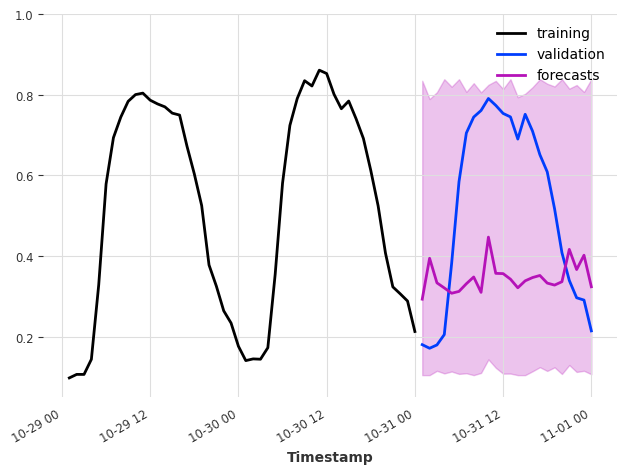

In [12]:
pred_samples = model.predict(n=24, num_samples=100)
pred_params = model.predict(n=1, num_samples=1, predict_likelihood_parameters=True)

for val, comp in zip(pred_params.values()[0], pred_params.components):
    print(f"{comp} : {round(val, 3)}")

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:24].plot(label="validation")
pred_samples.plot(label="forecasts")
plt.tight_layout()
plt.ylim(0.05, 1);

In the example above, due to the oscillating nature of the target, the model is struggling to forecast the median but the 0.5 and 0.95 quantiles properly encompass the expected values.

## Sklearn-like models

Scikit-learn is one of the most popular machine learning libraries for Python and offers a wide range of model implementation. Darts `RegressionModel` is build to easily augment any the sklearn regression models to facilitate their use on timeseries forecasting tasks

### Built-in model

As described in the [Quickstart notebook](https://unit8co.github.io/darts/quickstart/00-quickstart.html#Regression-forecasting-models), fitting a Bayesian ridge regression on the example dataset takes only a few lines:

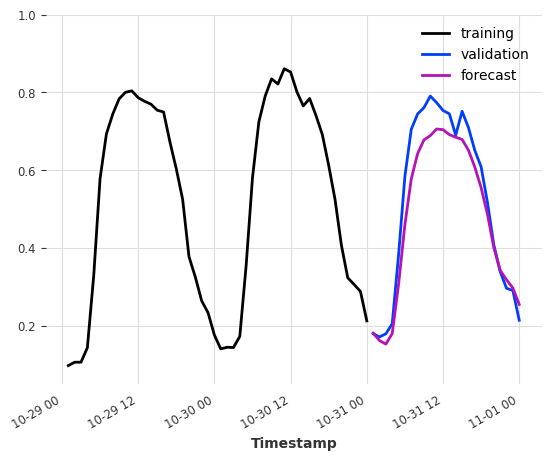

In [13]:
model = RegressionModel(
    lags=24,
    lags_future_covariates=(48, 24),
    model=BayesianRidge(),
    output_chunk_length=24,
)

model.fit(ts_energy_train, future_covariates=ts_weather)

pred = model.predict(n=24)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:24].plot(label="validation")
pred.plot(label="forecast")
plt.ylim(0.05, 1);

The underlying model methods remain accessible and by combining the `BasesianRidge.coef_` attribute with the `RegressionModel.lagged_feature_names` attribute, the coefficients of the regression model can easily be interpreted:

In [14]:
# extract the coefficients of the first timestemp estimator
coef_values = model.model.estimators_[0].coef_
# get the lagged features name
coef_names = model.lagged_feature_names
# combine them in a dict
coeffients = {name: val for name, val in zip(coef_names, coef_values)}
# see the coefficient of the target value at last timestep before the forecasted period
coeffients["Value_NE5_target_lag-1"]

1.456040904681576

One of the limitation of the `RegressionModel` class is that it does not provide probabilistic forecasting out of the box but it is possible to implement it by creating a new class inheriting from both `RegressionModel` and `_LikelihoodMixin` and implementing the missing methods (the `LinearRegressionModel` class could be use as a template).

### MultiOutputRegressor wrapper

Some regressor models do not support multi-output, which is necessary to fit and predict multivariates series. When such models are fitted on a series containing more than one components, Darts automatically wrap them in sklearn `MultiOutputRegressor` class and handle all the logic under the hood.

By doing so, the model is able to leverage all the components in the target series to predict each of them, effectively capture interaction between target variables.

**Note** : The `MultiOutputRegressor` is also used under the hood when `output_chunk_length>1` and `multi_models=True`.

### Custom model

It is of course possible to implement your own custom regression model as long as it works with tabular data and provides the `fit()` and `predict()` methods:

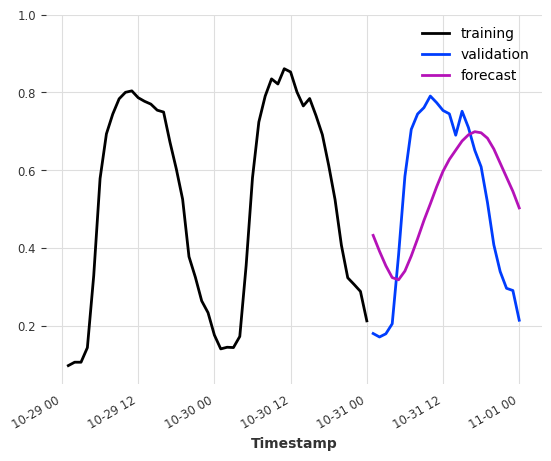

In [15]:
class CustomRegressionModel:
    def __init__(self, weights: np.ndarray):
        """Barebone weighted average"""
        self.weights = weights
        self.norm_coef = sum(weights)

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Sanity check of the arrays shape"""
        raise_if(
            X.shape[1] != self.weights.shape[0],
            "The total number of lags must be equal to the size of the weights window.",
        )
        return self

    def predict(self, X: np.ndarray):
        """Apply weights on each sample"""
        return (
            np.stack([np.correlate(x, self.weights, mode="valid") for x in X])
            / self.norm_coef
        )

    def get_params(self, deep: bool):
        return {"weights": self.weights}


window_weights = np.arange(1, 25, 1) ** 2
model = RegressionModel(
    lags=24,
    output_chunk_length=24,
    model=CustomRegressionModel(window_weights),
    multi_models=False,
)
model.fit(ts_energy_train)
pred = model.predict(n=24)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:24].plot(label="validation")
pred.plot(label="forecast")

plt.ylim(0.05, 1);

## External librairies

In addition to the sklearn regression model, Darts also offer an unified API for some state of the art regression models implemented in dedicated libraries such as:

* [LightGBM](https://lightgbm.readthedocs.io/en/stable/), a gradient boosting model developed and maintenained by Microsoft.
* [XGBoost](https://xgboost.readthedocs.io/en/stable/), another gradient boosting model.
* [Catboost](https://catboost.ai/en/docs/concepts/python-quickstart#regression), another gradient boost based model.

After making sure that the dependencies are properly installed, any of these model can be instanciated and compared in a few lines:

LightGBMModel MAPE: 6.336321179386335
XGBoostModel MAPE: 10.214015379997061
CatboostModel MAPE: 6.887123703259003


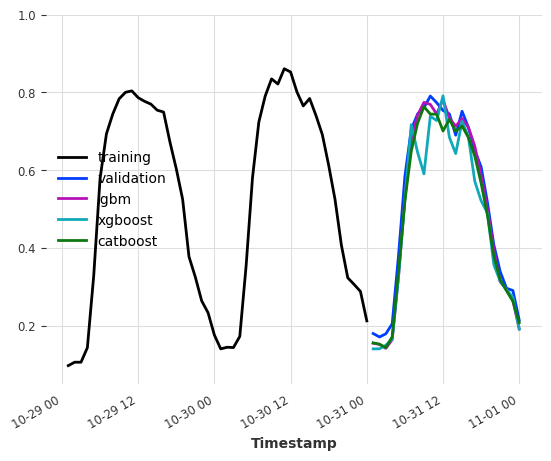

In [16]:
lgbm_model = LightGBMModel(lags=24, output_chunk_length=24, verbose=0)
xgboost_model = XGBModel(lags=24, output_chunk_length=24)
catboost_model = CatBoostModel(lags=24, output_chunk_length=24)

lgbm_model.fit(ts_energy_train)
xgboost_model.fit(ts_energy_train)
catboost_model.fit(ts_energy_train)

pred_lgbm = lgbm_model.predict(n=24)
pred_xgboost = xgboost_model.predict(n=24)
pred_catboost = catboost_model.predict(n=24)

print(f"LightGBMModel MAPE: {mape(ts_energy_val, pred_lgbm)}")
print(f"XGBoostModel MAPE: {mape(ts_energy_val, pred_xgboost)}")
print(f"CatboostModel MAPE: {mape(ts_energy_val, pred_catboost)}")

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:24].plot(label="validation")
pred_lgbm.plot(label="lgbm")
pred_xgboost.plot(label="xgboost")
pred_catboost.plot(label="catboost")
plt.ylim(0.05, 1);

With the default parameters, LightGBM and Catboost models display similar performance but it is of course necessary to perform hyper-parameters tuning in order to identify the most promising approach (see [Hyper-parameters optimization notebook](https://unit8co.github.io/darts/examples/17-hyperparameter-optimization.html)).

## Explainability

The `ShapExplainer` class from the explainability module of Darts is based on [shap](https://github.com/shap/shap), a library based on game theoric, which allows to get better insights in a model coefficients and forecasts:

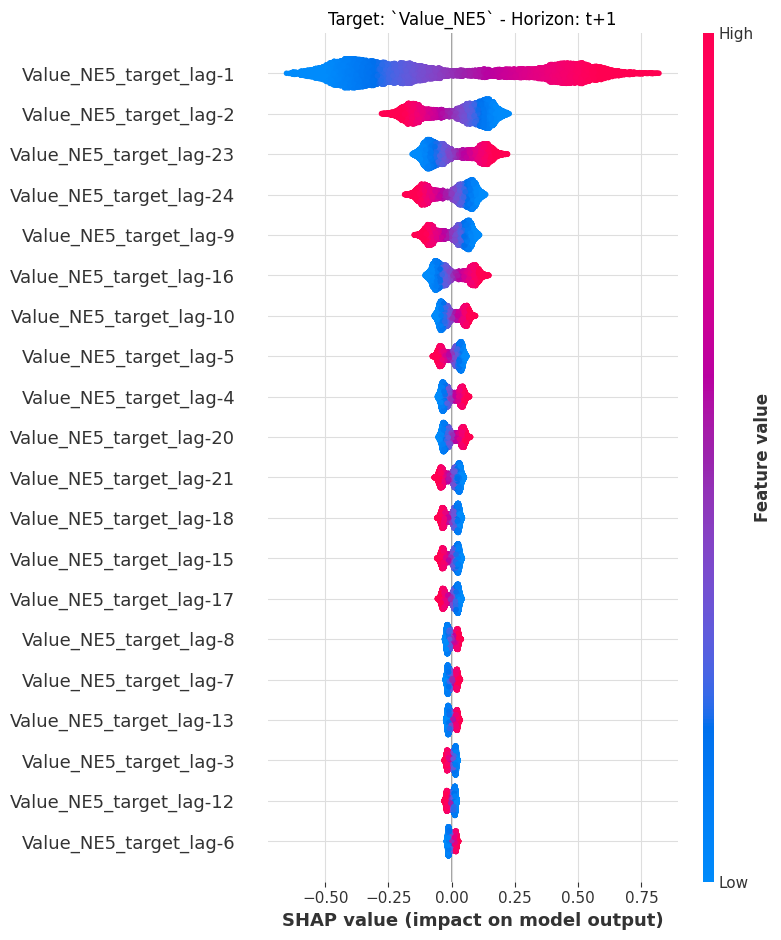

In [17]:
model = LinearRegressionModel(lags=24, lags_future_covariates=(24, 24))
model.fit(ts_energy_train, future_covariates=ts_weather)
shap_explainer = ShapExplainer(model=model)
shap_explainer.summary_plot()

In [18]:
# extracting the end of each series to reduce computation time
foreground_target = ts_energy_train[-24 * 2 :]
foreground_future_cov = ts_weather[foreground_target.start_time() :]

shap_explainer.force_plot_from_ts(
    foreground_series=foreground_target,
    foreground_future_covariates=foreground_future_cov,
)

## Conclusion

By tabularizing the data and uniformizing the API across libraries, Darts closes the gap between traditional regression problems and timeseries forecasting.

`RegressionModel` and its sub-classes offer a wide range of functionnalities and can be used to obtain performant baseline models in a few lines of codes. If their performance is not satisfactory or your dataset is large enough, you can then easily compare them with state-of-the-art deep learning models.